In [3]:
import astropy.constants as const
import copy
import corrcal
import healpy
import hera_sim
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import uvtools

from astropy import units
from astropy.coordinates import EarthLocation, SkyCoord, Angle, AltAz
from astropy.time import Time
from hera_sim.utils import jansky_to_kelvin
from numba import njit, prange
from pathlib import Path
from pyuvdata import UVData, UVBeam
from pyradiosky import SkyModel
from scipy import interpolate, stats
%matplotlib inline

In [4]:
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 12

In [5]:
path = Path(os.getcwd())
files = list(path.glob("*.uvh5"))
# test_file = next(f for f in files if "foregrounds.true" in str(f))
test_file = next(f for f in files if "lowband" in str(f))

In [6]:
home = Path(os.path.expanduser('~'))
beam_path = home / "HERA/HERA-Beams/NicolasFagnoniBeams"
beam_file = beam_path / "NF_HERA_Dipole_efield_beam.fits"
assert beam_file.exists()

In [7]:
uvd = UVData()
uvd.read(test_file, ant_str="cross")  # Only crosscorrs

Telescope RIMEz calculation is not in known_telescopes.


In [8]:
# Pull out data for one integration and one freq channel
ref_freq = 124.3e6
chan = np.argmin(np.abs(uvd.freq_array[0] - ref_freq))
Nbls = uvd.Nbls
times, inds = np.unique(uvd.time_array, return_index=True)
lsts = uvd.lst_array[inds]
data = uvd.data_array[uvd.time_array==times[-1], 0, chan, 0]

# Group it by redundancy
wavelength = const.c.si.value / uvd.freq_array.flatten()[chan]
u, v, w = uvd.uvw_array[:Nbls].T / wavelength
sort, edges, conj = corrcal.gridding.make_redundant_groups(u, v)
data = data[sort]  # Group by redundancy
data[conj] = np.conj(data[conj])

# Now get the relevant antenna information
ant_1_array = uvd.ant_1_array[:Nbls][sort]
ant_2_array = uvd.ant_2_array[:Nbls][sort]
tmp = ant_1_array.copy()
ant_1_array[conj] = ant_2_array[conj]
ant_2_array[conj] = tmp[conj]
antennas = list(uvd.antenna_numbers)
ant_1_inds = np.array([antennas.index(ant) for ant in ant_1_array])
ant_2_inds = np.array([antennas.index(ant) for ant in ant_2_array])

In [9]:
egsm_file = Path(os.getcwd()) / "egsm_pred_50_200mhz.h5.npz"
assert egsm_file.exists()

In [10]:
d = dict(np.load(egsm_file))
Isky = d['imap'] * units.MJy / units.sr
Isky = Isky.to("Jy/sr")
sky_freqs = d['freqs'] * units.GHz

In [11]:
this_slice = (sky_freqs.value > 0.120) & (sky_freqs.value < 0.130)
Isky = Isky[this_slice,:]
sky_freqs = sky_freqs[this_slice]
nfreq, npix = Isky.shape
nside = healpy.npix2nside(npix)

In [12]:
raw_map = Isky[0].value
raw_angular_pspec = healpy.anafast(raw_map, lmax=ell_max)

NameError: name 'ell_max' is not defined

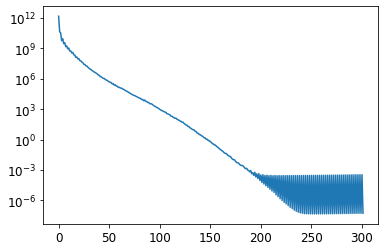

In [531]:
plt.semilogy(raw_angular_pspec)

In [388]:
# Rotate the map to be in the same coordinate system as the beam
lat, lon, alt = uvd.telescope_location_lat_lon_alt
lst = lsts[-1]
rotator = healpy.rotator.Rotator(
    rot=None,
    coord=('G', 'E'),
)

# Quick check to see that the rotation actually works.
alm_egsm = healpy.map2alm(Isky[0].value)
alm_egsm_rot = alm_egsm.copy()
rotator.rotate_alm(alm_egsm_rot, inplace=True)
ecef_map = healpy.alm2map(alm_egsm_rot, nside=nside)
healpy.rotate_alm(alm_egsm_rot, 0, np.pi / 2 - lat, -lst)
rot_map = healpy.alm2map(alm_egsm_rot, nside=nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [389]:
stokes = np.zeros((4, nfreq, npix), dtype=Isky.dtype)
for i in range(nfreq):
    # Rotate each map individually
    alm = healpy.map2alm(Isky[i].value)
    rotator.rotate_alm(alm, inplace=True)
    healpy.rotate_alm(alm, 0, np.pi / 2 - lat, -lst)
    rotated_map = healpy.alm2map(alm, nside)
    stokes[0,i] = rotated_map
    
sky_model = SkyModel(
    stokes=stokes * units.Jy / units.sr,
    spectral_type="subband",
    freq_array=sky_freqs,
    nside=nside,
    hpx_inds=np.arange(npix),
)

In [390]:
this_freq = uvd.freq_array[0,chan]
this_map = sky_model.at_frequencies(
    np.array([this_freq]) * units.Hz, inplace=False
)
az = sky_model.ra.value
za = np.pi / 2 - sky_model.dec.value
above_horizon = za < np.pi / 2
map_with_horizon_cut = this_map.stokes[0,0,:].value
map_with_horizon_cut[~above_horizon] = 0

In [391]:
# We should choose the grid size so that the Fourier transform
# will include all of the uv-modes we sample with the array.
# So, let's figure that out.
# Note that spacing in the image plane is 2 / Npix, so the
# highest u-mode sampled for a plane with Npix pixels along
# a side is Npix / 4.
baselines = {}
uvws = {}
pos, ants = uvd.get_ENU_antpos()
antpos = dict(zip(ants, pos))
for antpair in uvd.get_antpairs():
    ai, aj = antpair
    baseline = antpos[aj] - antpos[ai]
    baselines[antpair] = baseline
    uvws[antpair] = this_freq * baseline / const.c.si.value
uvw_array = np.vstack(list(uvws.values()))
umax = np.abs(uvw_array[:,0]).max()
vmax = np.abs(uvw_array[:,1]).max()
Npix = int(4 * np.ceil(max(umax, vmax))) + 1
print(umax, vmax, Npix)

33.53287560484989 31.680351763080356 137


In [392]:
lm_grid_size = Npix
ell_grid = np.linspace(-1, 1, lm_grid_size)
L, M = np.meshgrid(ell_grid, ell_grid, indexing="xy")

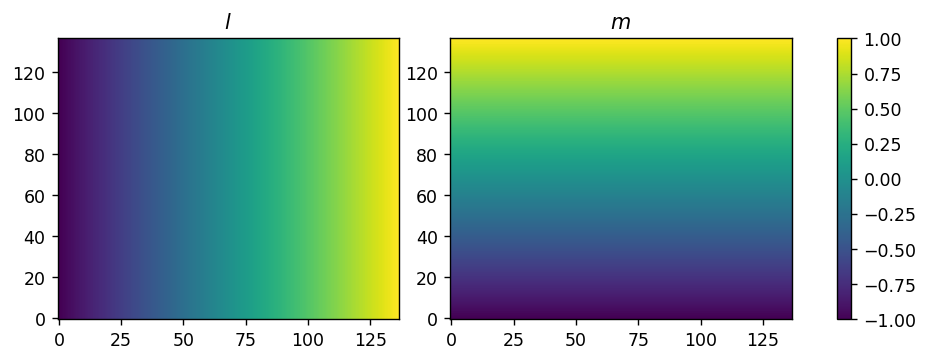

In [393]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3), dpi=125)
extent = (ell_grid.min(), ell_grid.max(), ell_grid.min(), ell_grid.max())
axes[0].set_title("$l$")
axes[1].set_title("$m$")
axes[0].imshow(L, origin="lower", aspect='auto')#, extent=extent)
cax = axes[1].imshow(M, origin="lower", aspect='auto')#, extent=extent)
fig.tight_layout()
fig.colorbar(cax, ax=axes);

In [1]:
import healpy

In [ ]:
healpy.

In [2]:
healpy.mollview?

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
0.0 180.0 -180.0 180.0
The interval b

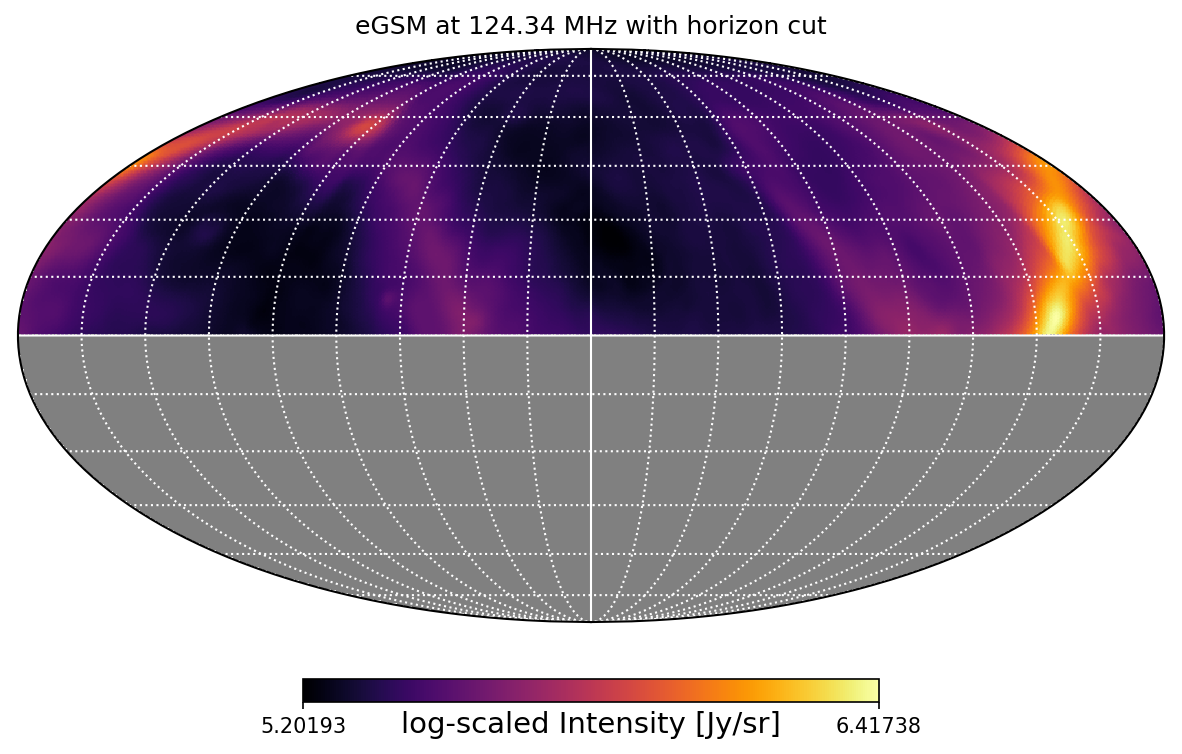

In [394]:
fig = plt.figure(figsize=(8,8), dpi=150)
plot_map = map_with_horizon_cut.copy()
plot_map[~above_horizon] = np.nan
healpy.mollview(
    np.log10(plot_map),
    title=f"eGSM at {(this_freq * units.Hz).to('MHz'):.2f} with horizon cut",
    unit="log-scaled Intensity [Jy/sr]",
    fig=1,
    cmap='inferno',
    badcolor='grey',
    bgcolor='white',
)
healpy.graticule(dpar=15,dmer=20, color='white')

In [395]:
gridded_intensity = np.zeros_like(L)
hpx_l = np.sin(za) * np.cos(az)
hpx_m = np.sin(za) * np.sin(az)
kernel_size = 3 * np.median(np.diff(ell_grid))
tol = 0.01
for row in range(lm_grid_size):
    for col in range(lm_grid_size):
        l_here, m_here = L[row,col], M[row,col]
        if np.sqrt(l_here**2 + m_here**2) >= 1-tol: continue
        neighbors = np.sqrt((hpx_l - l_here)**2 + (hpx_m - m_here)**2) < kernel_size
        gridded_intensity[row,col] = np.average(map_with_horizon_cut[neighbors]) / np.sqrt(1 - l_here**2 - m_here**2)

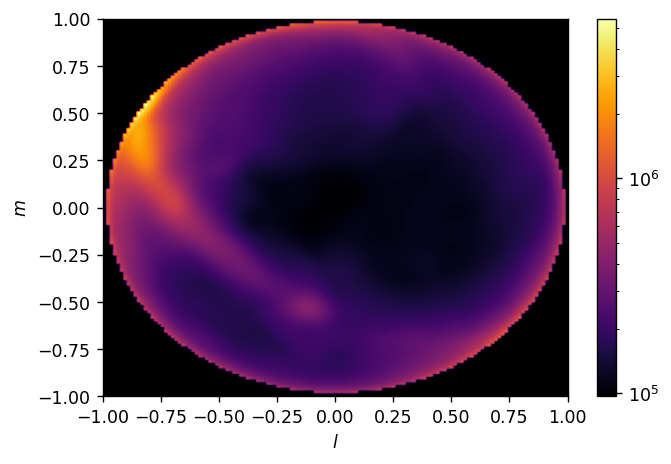

In [396]:
cmap = copy.copy(plt.cm.inferno)
norm = plt.cm.colors.LogNorm(gridded_intensity[gridded_intensity>0].min(), gridded_intensity.max())
cmap.set_bad()
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=125)
ax.set_xlabel("$l$")
ax.set_ylabel("$m$")
ax.imshow(gridded_intensity, aspect='auto', extent=extent, cmap=cmap, norm=norm)
cbar = fig.colorbar(smap, ax=ax);

In [397]:
I_fft = np.fft.fftshift(np.fft.fft2(gridded_intensity)) * np.median(np.diff(ell_grid))**2
sky_pspec = np.abs(I_fft) ** 2
u_samp = uvtools.utils.fourier_freqs(ell_grid)

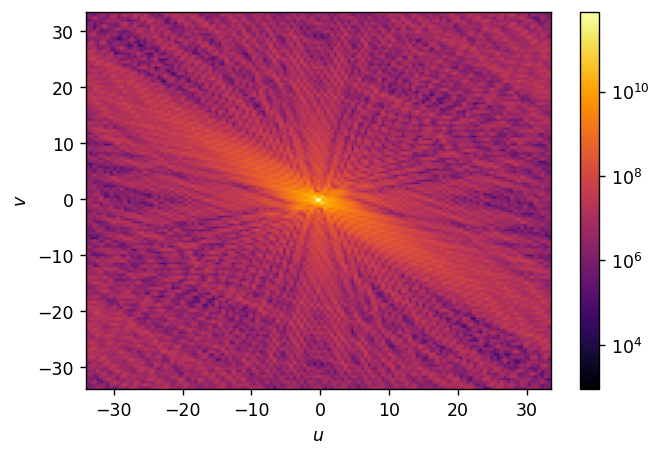

In [398]:
fft_extent = (u_samp.min(), u_samp.max(), u_samp.min(), u_samp.max())
fft_cmap = plt.cm.inferno
fft_norm = plt.cm.colors.LogNorm(vmin=sky_pspec.min(), vmax=sky_pspec.max())
fft_smap = plt.cm.ScalarMappable(cmap=fft_cmap, norm=fft_norm)
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=125)
ax.set_xlabel("$u$")
ax.set_ylabel("$v$")
ax.imshow(sky_pspec, cmap=fft_cmap, norm=fft_norm, aspect='auto', extent=fft_extent)
fig.colorbar(fft_smap, ax=ax);

In [407]:
u_mesh, v_mesh = np.meshgrid(u_samp, u_samp, indexing="xy")
u_mags = np.sqrt(u_mesh**2 + v_mesh**2)
du = np.median(np.diff(u_samp))
u_bin_edges = np.linspace(0, u_mags.max() + 0.5*du, Npix // 2)
cyl_pspec = stats.binned_statistic(
    u_mags.ravel(), sky_pspec.ravel(), statistic='mean', bins=u_bin_edges
)[0]
u_modes = 0.5 * (u_bin_edges[:-1] + u_bin_edges[1:])

In [408]:
logu = np.log(u_modes)
logP = np.log(cyl_pspec)
A = np.ones((logu.size, 2), dtype=float)
A[:,1] = logu
best_fit_params = np.linalg.inv(A.T @ A) @ A.T @ logP
best_fit = A @ best_fit_params
powerlaw_index = best_fit_params[1]
chisq = np.sum((logP-best_fit) ** 2)
err = chisq * np.linalg.inv(A.T @ A) / (logP.size - 2)

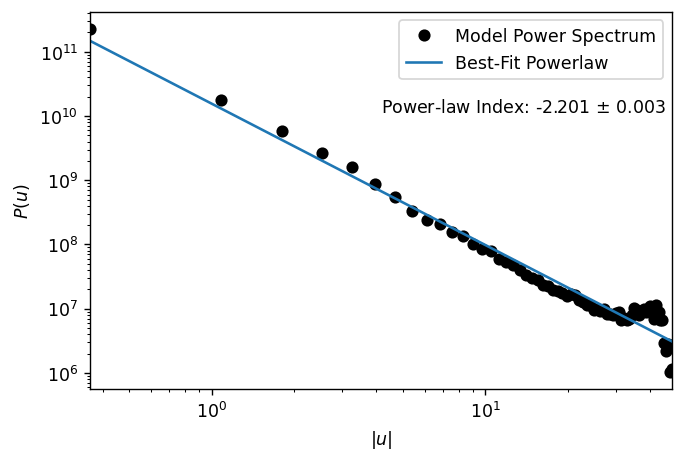

In [410]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=125)
ax.set_xlabel("$|u|$")
ax.set_ylabel("$P(u)$")
ax.loglog(u_modes, cyl_pspec, 'ko', label="Model Power Spectrum")
ax.loglog(u_modes, np.exp(best_fit), label="Best-Fit Powerlaw")
ax.set_xlim(u_modes.min(), u_modes.max())
fit_info = f"Power-law Index: {powerlaw_index:.3f} " + r"$\pm$ " + f"{err[1,1]:.3f}"
ax.text(0.99, 0.77, fit_info, ha="right", va="top", transform=ax.transAxes)
ax.legend();

In [411]:
ell_max = int(2 * np.pi * u_modes.max())
ang_pspec = healpy.anafast(this_map.stokes[0,0].value, lmax=ell_max)
ells = np.arange(ang_pspec.size)
ang_bandpowers = ells * (ells+1) * ang_pspec / (2 * np.pi)

In [ ]:
# do this check with haslam map, check lambda archive

In [547]:
healpy.npix2nside(raw_map.size)

128

In [549]:
2 * np.pi / 180

0.03490658503988659

In [552]:
np.pi / healpy.nside2resol(128) / 2

196.4787279257258

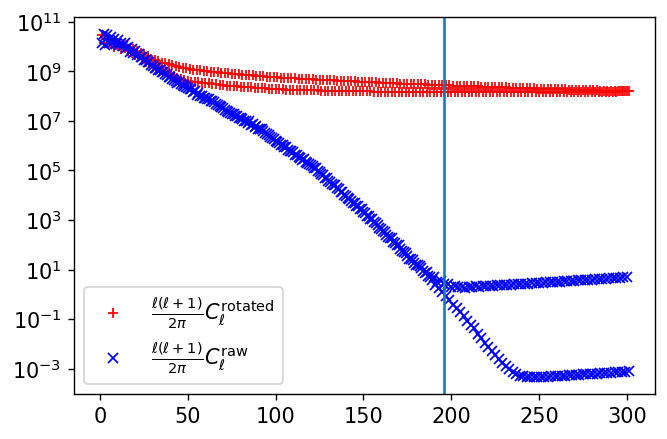

In [556]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=125)
ax.semilogy(ells, ang_bandpowers, 'r+', label=r"$\frac{\ell(\ell+1)}{2\pi}C_\ell^{\rm rotated}$")
ax.semilogy(ells*(ells+1)*raw_angular_pspec/(2*np.pi),'bx', label=r"$\frac{\ell(\ell+1)}{2\pi}C_\ell^{\rm raw}$")
ax.axvline(196)
ax.legend(loc="lower left")
# ax.set_xlim(50,200)
# ax.set_ylim(1e4,1e8)
fig.savefig("angular_pspec_comparison.pdf")

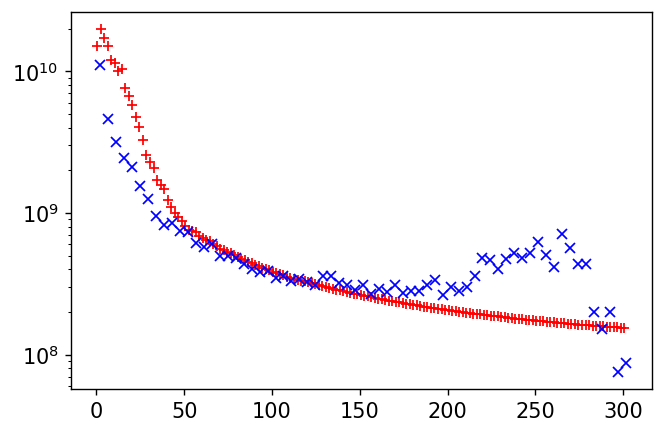

In [538]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=125)
ax.semilogy(0.5*(ells[0::2] + ells[1::2]), 0.5*(ang_bandpowers[0::2]+ang_bandpowers[1::2]), 'r+')
ax.semilogy(2*np.pi*u_modes, cyl_pspec * u_modes**1.5 / (2 * np.pi**2)**0.5, 'bx')

In [277]:
beam = UVBeam()
beam.read_beamfits(str(beam_file))
beam.interpolation_function = 'az_za_simple'
beam.freq_interp_kind = 'cubic'

In [280]:
above_horizon = za <= np.pi / 2
interp_beam = beam.efield_to_power(
    calc_cross_pols=False, inplace=False
)
interp_beam.peak_normalize()

In [282]:
interp_beam = interp_beam.interp(
    az_array=az[above_horizon],
    za_array=za[above_horizon],
    freq_array=np.array([this_freq]),
    polarizations=['xx',],
)[0][0,0,0,0]

In [283]:
gridded_beam = np.zeros(L.shape, dtype=interp_beam.dtype)
nsample_beam = np.zeros(L.shape, dtype=int)
for i, (_az, _za) in enumerate(zip(az[above_horizon], za[above_horizon])):
    this_l = np.sin(_za) * np.cos(_az)
    this_m = np.sin(_za) * np.sin(_az)
    ell_dist = np.abs(L - this_l)
    emm_dist = np.abs(M - this_m)
    this_pixel = (ell_dist == ell_dist.min()) & (emm_dist == emm_dist.min())
    gridded_beam[this_pixel] += interp_beam[i]
    nsample_beam[this_pixel] += 1

gridded_beam[nsample_beam != 0] /= nsample_beam[nsample_beam != 0]

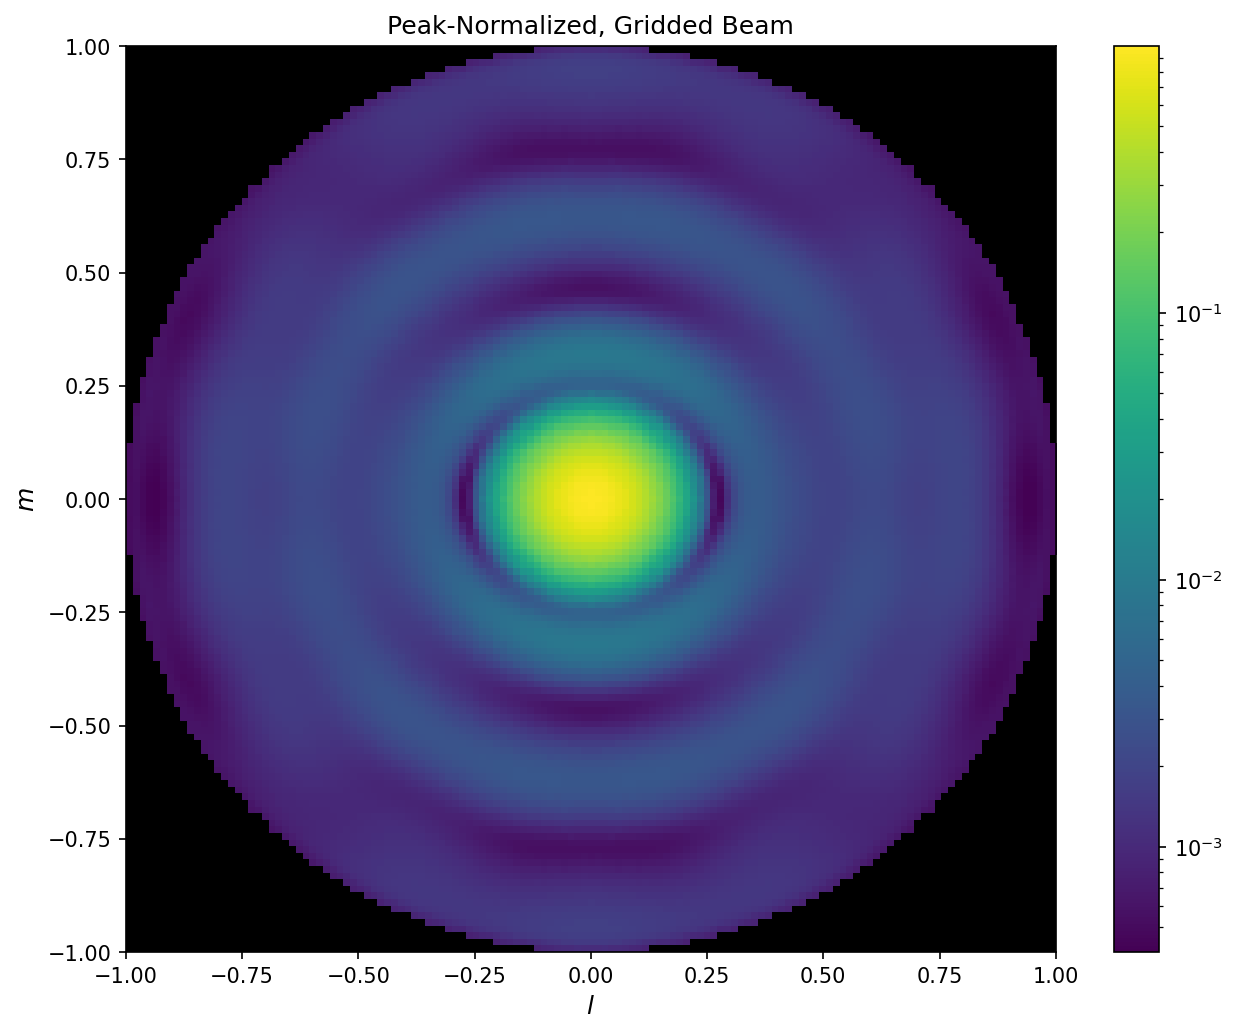

In [284]:
fig, ax = plt.subplots(
    1, 1, figsize=(10,8), subplot_kw=dict(facecolor='k'), dpi=150
)
cax = ax.imshow(
    gridded_beam,
    origin='lower',
    aspect='auto',
    norm=plt.cm.colors.LogNorm(),
    extent=(-1, 1, -1, 1),
)
fig.colorbar(cax)
ax.set_xlabel("$l$", fontsize=12)
ax.set_ylabel("$m$", fontsize=12)
ax.set_title("Peak-Normalized, Gridded Beam", fontsize=12)
fig.savefig("gridded_beam_example.png", bbox_inches='tight', dpi=150)

In [285]:
# Now get the uv kernel for the beam
beam_kernel = np.fft.fftshift(
    np.fft.fft2(gridded_beam)
) * np.mean(np.diff(l)) ** 2

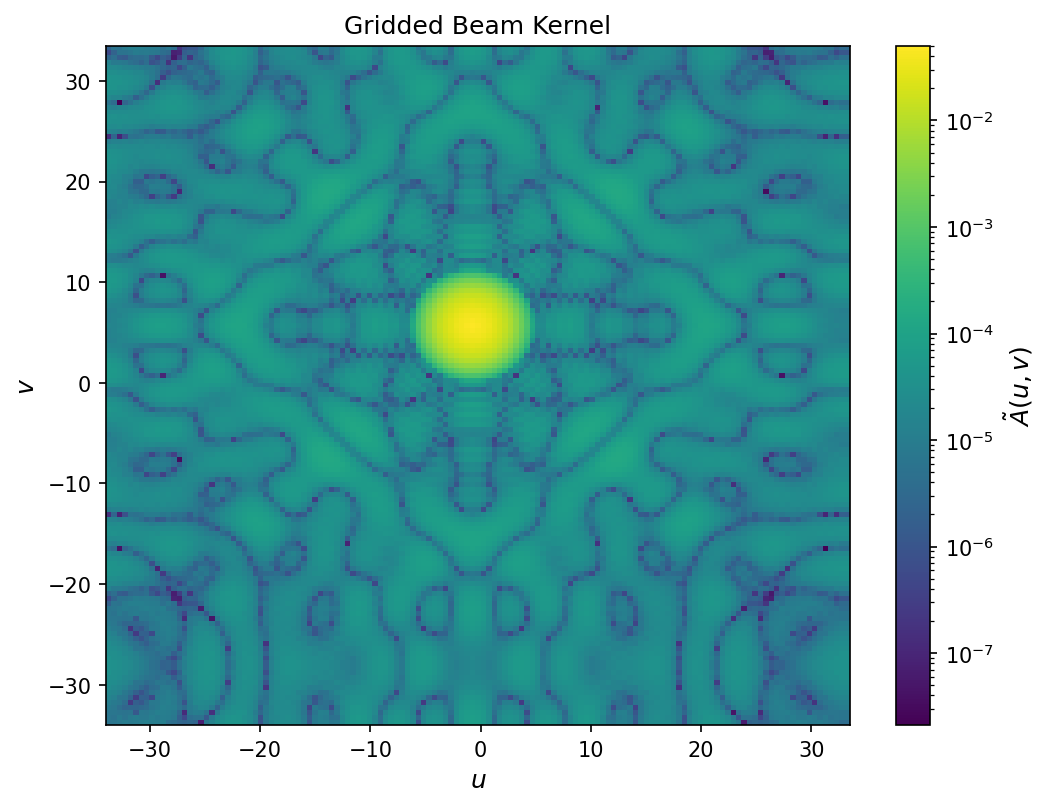

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=150)
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
cax = ax.imshow(
    np.abs(np.roll(beam_kernel, shift, axis=(0,1))),
    origin='lower',
    aspect='auto',
    norm=plt.cm.colors.LogNorm(),
    extent=(u_samp.min(), u_samp.max(), u_samp.min(), u_samp.max()),
)
ax.set_xlabel("$u$", fontsize=12)
ax.set_ylabel("$v$", fontsize=12)
ax.set_title(r"Gridded Beam Kernel", fontsize=12)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label(r"$\tilde{A}(u,v)$", fontsize=12)
# fig.savefig("example_gridded_beam_kernel.png", bbox_inches='tight', dpi=150)
# fig.savefig("cool_picture.png", bbox_inches="tight", dpi=150)

In [428]:
origin = np.array([np.abs(u_samp).min(),] * 2)
enu_pos = uvd.get_ENU_antpos()[0]
uvws = enu_pos[ant_2_inds,:] - enu_pos[ant_1_inds,:]
uv = uvws[:,:2]
uv_shift = (uv - origin) / (u_samp[1] - u_samp[0])
uv_shift = np.around(uv_shift, 0).astype(int)
t1 = time.time()
diff_mat = np.zeros((Nbls, u_samp.size**2), dtype=complex)
for i, shift in enumerate(uv_shift):
    diff_mat[i] = np.roll(beam_kernel, shift, axis=(0,1)).flatten() * np.sqrt(sky_pspec).flatten()
diff_cov = diff_mat @ diff_mat.T.conj()
t2 = time.time()
print(f"Took {(t2-t1)/60} minutes to make diffuse covariance.")

Took 0.008190631866455078 minutes to make diffuse covariance.


In [435]:
t1 = time.time()
diff_mat = np.zeros((Nbls, edges.size-1), dtype=complex)
origin = np.array([np.abs(u_samp).min(),] * 2)
enu_pos = uvd.get_ENU_antpos()[0]
uvws = enu_pos[ant_2_inds,:] - enu_pos[ant_1_inds,:]
uv = uvws[:,:2]
for group, (start, stop) in enumerate(zip(edges, edges[1:])):
    uv_here = uv[start]
    shift = np.around(
        (uv_here - origin) / (u_samp[1] - u_samp[0]), 0
    ).astype(int)
    diff_mat[start:stop,group] = np.sqrt(
        np.sum(
            np.abs(
                np.roll(beam_kernel, shift, axis=(0,1)).flatten()
            )**2 * sky_pspec.flatten()
        )
    )
diff_cov = diff_mat @ diff_mat.T.conj()
t2 = time.time()
print(f"Took {(t2-t1)/60} minutes to make diffuse covariance.")

Took 0.0007965366045633951 minutes to make diffuse covariance.


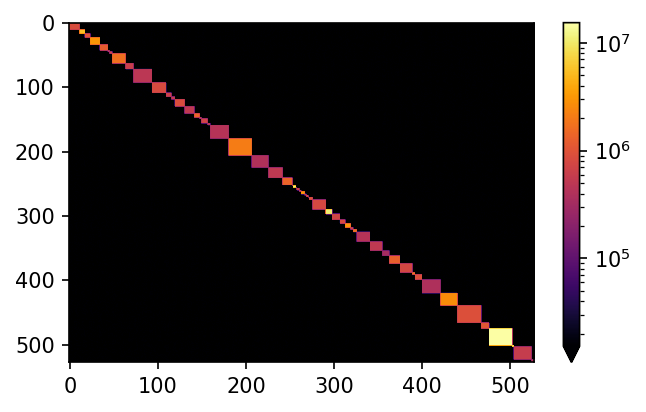

In [436]:
cmap = copy.copy(plt.cm.inferno)
norm = plt.cm.colors.LogNorm(vmin=1e-3*np.abs(diff_cov).max())
cmap.set_bad()
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=150)
ax.imshow(np.abs(diff_cov), cmap=cmap, norm=norm, aspect='auto')
fig.colorbar(smap, ax=ax, extend="min")

## Point Source Model Construction

In [239]:
# Fornax A parameters taken from: https://arxiv.org/abs/1410.0790
fornax_ra = Angle("3:22:41.789", unit="hourangle").to("deg")
fornax_dec = Angle("-37:12:29.52", unit="degree")
fornax_flux = 786.0 * units.Jy  # at 120 MHz

In [244]:
gleam_file = "gleam-120.02-127.34MHz-nf-76-pld.skyh5"
assert os.path.exists(gleam_file)

In [246]:
gleam_model = SkyModel.from_skyh5(gleam_file)
gleam_model.spectral_type = "subband"
gleam_model.at_frequencies(np.array([ref_freq,]) * units.Hz)

In [247]:
ras = gleam_model.ra
decs = gleam_model.dec
fluxes = gleam_model.stokes[0,0,:]

In [253]:
ras = ras.insert(0, fornax_ra)
decs = decs.insert(0, fornax_dec)
fluxes = fluxes.insert(0, fornax_flux)

In [448]:
# Roughly following steps in HERA Memo 46 to transform coords
modified_jd = uvd.time_array[0] - 2400000.5
lat, lon, alt = uvd.telescope_location_lat_lon_alt
lat = Angle(lat, unit=units.rad)
lon = Angle(lon, unit=units.rad)
obstime = Time(modified_jd, format="mjd", location=(lon, lat))
local_frame = AltAz(
    location=EarthLocation.from_geocentric(*uvd.telescope_location, unit=units.m),
    obstime=obstime,
)
source_positions = SkyCoord(ra=ras, dec=decs, frame="icrs")
local_positions = source_positions.transform_to(local_frame)

In [449]:
beam = UVBeam()
beam.read_beamfits(str(beam_file))
beam.interpolation_function = 'az_za_simple'
beam.freq_interp_kind = 'cubic'
az = local_positions.az.to("rad").value
za = np.pi / 2 - local_positions.alt.to("rad").value
above_horizon = za <= np.pi / 2
is_bright = fluxes.to("Jy").value > 10
select = is_bright & above_horizon
interp_beam = beam.efield_to_power(
    calc_cross_pols=False, inplace=False
)
interp_beam.peak_normalize()
interp_beam = interp_beam.interp(
    az_array=az[select],
    za_array=za[select],
    freq_array=np.array([ref_freq]),
    polarizations=['xx',],
)[0][0,0,0,0]

In [450]:
Nsrc = select.sum()
az_here = az[select]
za_here = za[select]
flux_here = fluxes[select]
src_cov = np.zeros((Nbls,Nbls), dtype=complex)
src_pcov = np.zeros_like(src_cov)
base_flux = (flux_here * interp_beam).value
phs_prefac = -2j * np.pi * ref_freq / const.c.si.value
directions = np.array(
    [
        [np.sin(z) * np.cos(a), np.sin(z) * np.sin(a), np.cos(z)]
        for z, a in zip(za_here, az_here)
    ]
)
positions = np.vstack(list(antpos.values()))
baselines = positions[ant_2_inds] - positions[ant_1_inds]
t1 = time.time()
src_mat = base_flux[None,:] * np.exp(phs_prefac * np.einsum("ik,jk->ij", baselines, directions))
src_cov = src_mat @ src_mat.T.conj()
t2 = time.time()
print(f"Took {(t2-t1)/60} minutes.")

Took 0.00034809509913126627 minutes.


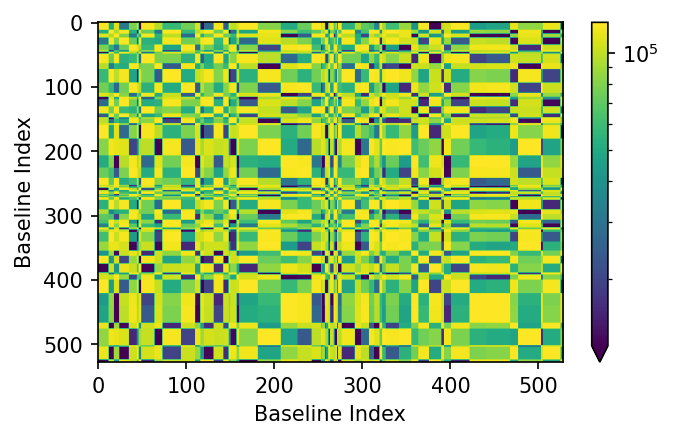

In [451]:
cmap = copy.copy(plt.cm.viridis)
cmap.set_bad()
norm = plt.cm.colors.LogNorm(vmin=1e-1*np.abs(src_cov).max(), vmax=None)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=150)
ax.set_xlabel("Baseline Index")
ax.set_ylabel("Baseline Index")
ax.imshow(np.abs(src_cov.real), aspect='auto', cmap=cmap, norm=norm)
cbar = fig.colorbar(smap, ax=ax, extend="min")
# fig.savefig("source_covariance_example.png", dpi=150, bbox_inches="tight")

## Testing

In [559]:
@njit
def _diagmul(mat, diag):
    """
    Multiply ``mat`` by a diagonal matrix from the left.
    
    Notes
    -----
    Slightly slower than ``matmul`` for small matrices, but saves time/resources
    when dealing with larger matrices.
    """
    out = np.zeros_like(mat)
    for i in prange(mat.shape[0]):
        out[i] = mat[i] * diag[i]
    return out

def diagmul(left, right):
    if left.ndim == 1:
        return _diagmul(right, left)
    else:
        return _diagmul(left.T, right).T

In [585]:
%%timeit
diagmul(A, B)

331 ms ± 67.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [586]:
%%timeit
A @ np.diag(B)

1.08 s ± 45.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [582]:
A = np.random.normal(size=(5000,3700))
B = np.random.normal(size=3700)
C = np.random.normal(size=5000)

In [576]:
np.allclose(vecmul(A.T, C), C @ A)

True

In [570]:
@njit
def vecmul(mat, vec):
    """
    Multiply a vector by a matrix from the left.
    """
    out = np.zeros(mat.shape[0], dtype=mat.dtype)
    for i in prange(mat.shape[0]):
        for j in prange(mat.shape[1]):
            out[i] += mat[i,j] * vec[j]
    return out

In [339]:
Nants = uvd.Nants_data

In [452]:
# Add some realistic noise
this_time = times[-1]
uvdata_autos = UVData()
uvdata_autos.read(
    test_file,
    ant_str='auto',
    times=np.array([this_time]),
    freq_chans=np.array([chan]),
)
autovis = uvdata_autos.get_data(0,0,'xx')[0,0].real

Telescope RIMEz calculation is not in known_telescopes.


In [341]:
# Need to get the beam area, so
hpx_beam = beam.interp(freq_array=np.array([this_freq]), new_object=True)
hpx_beam.efield_to_power(calc_cross_pols=False)
hpx_beam.select(polarizations=np.array([-5,]))
hpx_beam.to_healpix(nside=2**4)
hpx_beam.peak_normalize()

In [453]:
omega_p = hpx_beam.get_beam_area(pol="xx")
Jy2T = jansky_to_kelvin(freqs=this_freq / 1e9, omega_p=omega_p)
Trx = 100
rx_vis = Trx / Jy2T
inttime = uvd.integration_time[0]
channel_width = uvd.channel_width
# This is the noise variance according to the radiometer equation
noise_variance = (autovis + rx_vis) ** 2 / (inttime * channel_width)

In [454]:
hera_sim.defaults.set("h1c")
sim = hera_sim.Simulator(data=uvd.copy())
sim.add("thermal_noise", seed="initial", Trx=100, omega_p=omega_p, autovis=autovis)

In [455]:
noisy_data = sim.data.data_array[uvd.time_array==uvd.time_array[0],0,chan,0]
noisy_data = noisy_data[sort]
noisy_data[conj] = np.conj(noisy_data[conj])

In [456]:
noise = np.eye(noisy_data.size, dtype=complex) * noise_variance

In [358]:
g = np.zeros(2*Nants,dtype=float)
g[:Nants] = 1

In [361]:
def build_gain_mat(gains, ant_1_inds, ant_2_inds):
    # Assume gains are real/im split, output complex gain matrix
    nants = gains.size // 2
    complex_gains = gains[:nants] + 1j * gains[nants:]
    return complex_gains[ant_1_inds] * complex_gains[ant_2_inds].conj()

In [377]:
def simple_nll(gains, data, noise, cov, ant_1_inds, ant_2_inds, norm="det", scale=None):
    """Simple chi-squared routine.
    
    Assumes relevant quantities are complex-valued, but gains are real-valued
    """
    gain_mat = build_gain_mat(gains, ant_1_inds, ant_2_inds)
    scaled_cov = diagmul(gain_mat, diagmul(cov, gain_mat.conj()))
    inv_cov = np.linalg.inv(noise + scaled_cov)
    # Split things up so that we're guaranteed chisq is real-valued
    Nants = gains.size // 2
    Nbls = data.size
    re = slice(None,Nbls)
    im = slice(Nbls,None)
    split_data = np.zeros(2*Nbls, dtype=float)
    split_data[re] = data.real
    split_data[im] = data.imag
    split_cinv = np.zeros((2*Nbls, 2*Nbls), dtype=float)
    split_cinv[re,re] = inv_cov.real
    split_cinv[re,im] = -inv_cov.imag
    split_cinv[im,re] = inv_cov.imag
    split_cinv[im,im] = inv_cov.real
    if norm == "det":
        try:
            chol = np.linalg.cholesky(scaled_cov)
            norm = 2 * np.log(np.diag(chol).real).sum()
        except np.linalg.LinAlgError:
            norm = 1e10
    elif norm == "simple":
            norm = gains[Nants:].sum() ** 2 + (gains[:Nants].sum() - Nants) ** 2
    else:
        raise NotImplementedError
    return split_data @ vecmul(split_cinv, split_data) + norm

In [376]:
def simple_grad_nll(gains, data, noise, cov, ant_1_inds, ant_2_inds, norm="det", scale=1e-2):
    gain_mat = build_gain_mat(gains, ant_1_inds, ant_2_inds)
    nants = gains.size // 2
    complex_gains = gains[:nants] + 1j * gains[nants:]
    scaled_cov = diagmul(gain_mat, diagmul(cov, gain_mat.conj()))
    cinv = np.linalg.inv(noise + scaled_cov)
    scaled_data = vecmul(cinv, data)
    nvis = ant_1_inds.size
    grad_nll = np.zeros(2 * nants, dtype=float)
    for m in range(nants):
        for n in range(2):
            here = (slice(None,nants), slice(nants,None))[n]
            gain_mat_deriv = np.zeros_like(gain_mat)
            conj_gain_mat_deriv = np.zeros_like(gain_mat_deriv)
            if n == 0:
                # Derivative wrt real gain for ant m
                gain_mat_deriv[ant_1_inds==m] += np.conj(
                    complex_gains[ant_2_inds[ant_1_inds==m]]
                )
                gain_mat_deriv[ant_2_inds==m] += complex_gains[ant_1_inds[ant_2_inds==m]]
                conj_gain_mat_deriv[ant_1_inds==m] += complex_gains[ant_2_inds[ant_1_inds==m]]
                conj_gain_mat_deriv[ant_2_inds==m] += np.conj(
                    complex_gains[ant_1_inds[ant_2_inds==m]]
                )
            else:
                # Derivative wrt imag gain for ant m
                gain_mat_deriv[ant_1_inds==m] += 1j * np.conj(
                    complex_gains[ant_2_inds[ant_1_inds==m]]
                )
                gain_mat_deriv[ant_2_inds==m] -= 1j * complex_gains[ant_1_inds[ant_2_inds==m]]
                conj_gain_mat_deriv[ant_1_inds==m] -= 1j * complex_gains[ant_2_inds[ant_1_inds==m]]
                conj_gain_mat_deriv[ant_2_inds==m] += 1j * np.conj(
                    complex_gains[ant_1_inds[ant_2_inds==m]]
                )
            cov_deriv = diagmul(gain_mat_deriv, diagmul(cov, gain_mat.conj())) + diagmul(
                gain_mat, diagmul(cov, conj_gain_mat_deriv)
            )
            chisq_deriv = scaled_data.conj() @ vecmul(cov_deriv, scaled_data)
            if norm == "det":
                _norm = np.diag(cinv @ cov_deriv).sum()
            elif norm == "simple":
                if n == 0:  # real part
                    _norm = 2 * (complex_gains.real.sum() - nants)
                else:
                    _norm = 2 * complex_gains.imag.sum()
            else:
                raise NotImplementedError
            grad_nll[here][m] = np.real(chisq_deriv + _norm)
    return grad_nll * scale

In [364]:
def rephase_to_ant(complex_gains, ant=0):
    ref_gain = complex_gains[ant]
    conj_phase = ref_gain.conj() / np.abs(ref_gain)
    return complex_gains * conj_phase

In [460]:
full_cov = diff_cov + src_cov

In [463]:
simple_nll(init_gains, noisy_data, noise, full_cov, ant_1_inds, ant_2_inds, norm='simple')

8408.716596103635

In [446]:
simple_grad_nll(init_gains, noisy_data, noise, full_cov, ant_1_inds, ant_2_inds, norm='simple')

array([-24.4956452 ,  23.63651275,  70.93928652,  -1.01453051,
        69.54145036, -38.66819675, -16.13011521, -11.69617039,
        18.42278435,   4.13954227, -12.77010005,   4.85964153,
        72.54354431, -32.09733257, -47.61268707, -37.33798363,
         7.01524094, -21.59350098,  14.53260331,   1.62686349,
        14.26010035,  76.66646224, -12.22742746, -15.54461344,
        12.69696321, -19.87540174,  33.27796922,  22.6198325 ,
       -12.02504751,  -2.06053705,  20.34534662,  53.48384844,
         6.84187423,  -4.13868309, -11.77118189,   0.26683516,
        52.15522937, -13.90076631,  13.35126853, -18.62362486,
        -6.14957033,  -0.79354359,  41.24254023, -15.45644885,
       -32.8354347 , -23.83527608,  -7.1815561 , -17.82888094,
       -11.73523064, -25.0186855 ,   7.36821432, -33.7189636 ,
        25.91441455,  -7.05373109,  12.15494419,  54.01199047,
       -25.49196583,   1.72021092,  24.18993918,  33.29016134,
         0.99604525,  82.24860868,  20.45182518, -44.82

In [373]:
from scipy.optimize import fmin_cg

In [492]:
init_gains = g.copy()
init_gains[:Nants] = np.random.normal(loc=1, scale=1e-1, size=Nants)
init_gains[Nants:] = np.random.normal(loc=0, scale=1e-1, size=Nants)
fit_gains = fmin_cg(
    simple_nll, init_gains, fprime=simple_grad_nll,
    args=(noisy_data, noise, full_cov, ant_1_inds, ant_2_inds, "simple", 8e-6),
)

         Current function value: 7942.542652
         Iterations: 0
         Function evaluations: 50
         Gradient evaluations: 38


In [493]:
evals = np.linalg.eigvals(full_cov + noise)

In [494]:
evals.max() / evals.min()

(5180828.100925576-2.632105335546852e-05j)

In [490]:
grad_nll = simple_grad_nll(init_gains, noisy_data, noise, full_cov, ant_1_inds, ant_2_inds, norm='simple', scale=8e-6)

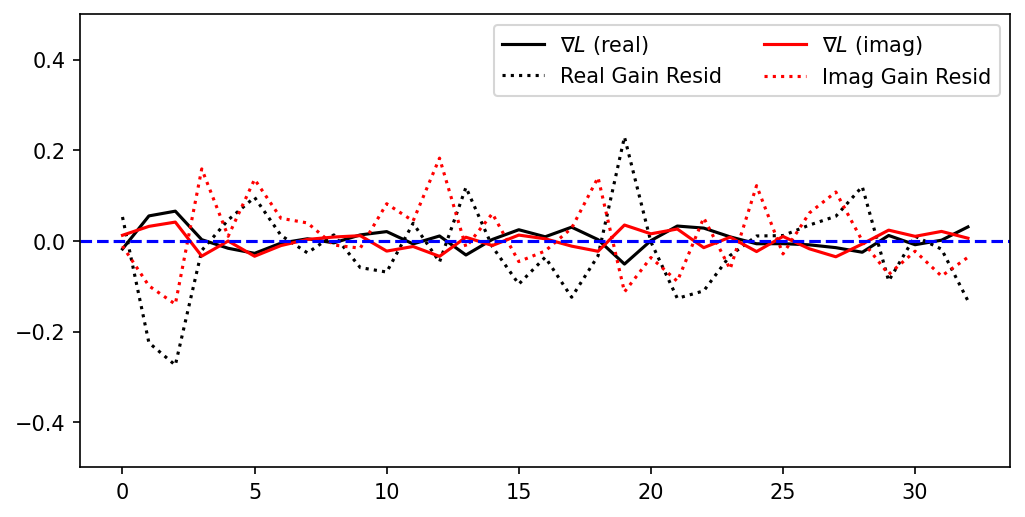

In [491]:
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150, facecolor="w")
ax.plot(grad_nll[:Nants], color='k', label=r"$\nabla L$ (real)")
ax.plot(init_gains[:Nants] - 1, color='k', ls=':', label="Real Gain Resid")
ax.plot(grad_nll[Nants:], color='r', label=r"$\nabla L$ (imag)")
ax.plot(init_gains[Nants:] - 0, color='r', ls=':', label="Imag Gain Resid")
ax.set_ylim(-0.5, 0.5)
ax.axhline(0, color='blue', ls='--')
ax.legend(ncol=2)

In [495]:
direct_inverse = np.linalg.inv(full_cov + noise)

In [502]:
def woodbury(A, U):
    eye = np.eye(U.shape[0], dtype=U.dtype)
    Ainv = np.linalg.inv(A)
    return Ainv - Ainv @ U @ np.linalg.inv(eye + U.T.conj() @ Ainv @ U) @ U.T.conj() @ Ainv

woodbury_inv = woodbury(noise, full_cov)

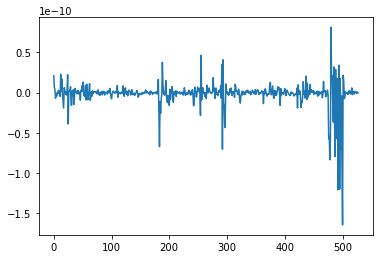

In [522]:
plt.figure(facecolor='w')
plt.plot(np.diag(np.real(direct_inverse @ (noise + full_cov))) - 1)

In [523]:
# try doing this with data drawn from the model covariance and see if the minimizer works

## Quick Check: Haslam Map

In [ ]:
haslam_fn = "haslam408_dsds_Remazeilles2014.fits"
haslam_model = SkyModel.fr